## Classification of resaurant
When you get restaurant recommendations as a user you might want a functionality to filter out restaurants on price range. As a restaurant owner you might want to know what other restaurant features influence your price tag. That's why we want to create a classification model that classifies restaurants into cheap, medium of expensive categories.

To do this we will try out different clasifiers on default settings and then do a gridsearch on the most promising ones to get the best model

In [1]:
from fastai.imports import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
original_df = pd.read_csv("../input/tripadvisor/restaurant_listings.csv")
pd.set_option("display.max_columns", None)


in short, we will do the same preprocessing as we did in sprint 1

In [2]:
#see notebook sprint 1 for details on how we got this
coords=pd.read_csv("../input/tripadvisor/coordinaten2.csv").replace(0,np.nan)

In [3]:
original_df["rank"]=original_df["rank"].str.replace("#","").astype(float)
original_df["general rating"]=original_df["general rating"].map(lambda x: x.split(" ")[0]).astype(float)
original_df["number of reviews"]=original_df["number of reviews"].map(lambda x: x.split(" ")[0].replace(",","")).astype(float)
original_df['city'] = original_df["address"].str.split(', ').str[-1].str.split(" ").str[0]
first_tag=original_df.tags.str.split("|",expand=True)[0].dropna()
ranges=first_tag[first_tag.str.find("$")!=-1]
original_df["price_tag"]=ranges
original_df=original_df.merge(coords,on="id")
original_df.drop(columns=["food rating", "service rating","price range"], inplace=True)

*NOTE* we can do this preprocessing on the original df because we are not aggregating data, each row is preprocessed individually (we are not using mean/mode/median/...)

In [4]:
original_df.columns

Index(['rank', 'restaurant name', 'general rating', 'number of reviews',
       'tags', 'address', 'phone number', 'website url', 'menu url',
       'timetable', 'email address', 'travelers choice', 'michelin',
       'value rating', 'atmosphere rating', 'description', 'dutch description',
       'cuisines', 'special diets', 'meals', 'restaurant features', 'id',
       'city', 'price_tag', 'latitude', 'longitude'],
      dtype='object')

now we will split the data and use a seed ;) but because we want to actually have price tags (our labels) we will remove them from our data first before making the train test split. In the end we can use our model to actually fill in the missing price tags 

In [5]:
df_with_price_tag=original_df[~original_df.price_tag.isna()].copy()

In [6]:
df_with_price_tag.price_tag

0       $$ - $$$
1           $$$$
2       $$ - $$$
3       $$ - $$$
4       $$ - $$$
          ...   
2563           $
2564           $
2566           $
2568    $$ - $$$
2574    $$ - $$$
Name: price_tag, Length: 1943, dtype: object

we will also remove features that won't help with the classification


In [7]:
df_with_price_tag.drop(columns=["restaurant name","address","phone number","website url","menu url","timetable","email address","id","tags"],inplace=True)

### descriptions

We can use the descriptions, we have 2 types. We will first see which ones are the most usefull

In [8]:
print(f"description is missing: {df_with_price_tag.description.isna().sum()}")
print(f"dutch description is missing {df_with_price_tag['dutch description'].isna().sum()}")
print(f"size trainingsset is {len(df_with_price_tag)}")

description is missing: 1497
dutch description is missing 1696
size trainingsset is 1943


we have too many missing values for description, 77% of the descriptions is missing so that's why we decided not to include this as a feature

In [9]:
df_with_price_tag.drop(columns=["description","dutch description"],inplace=True)
df_with_price_tag.head(2)

,rank,general rating,number of reviews,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,latitude,longitude
0,1.0,5.0,922.0,True,False,4.5,-1.0,"Thai, Healthy","Vegetarian Friendly, Vegan Options, Gluten Free Options","Dinner, Drinks","Reservations, Seating, Serves Alcohol, Free Wifi, Table Service, Gift Cards Available",Ghent,$$ - $$$,51.054899,3.722325
1,1.0,5.0,200.0,False,True,4.5,5.0,"French, Belgian, European","Vegetarian Friendly, Vegan Options, Gluten Free Options","Lunch, Dinner","Free Wifi, Reservations, Outdoor Seating, Seating, Parking Available, Free off-street parking, Wheelchair Accessible, Serves Alcohol, Accepts American Express, Accepts Mastercard, Accepts Visa, Accepts Credit Cards, Table Service, Highchairs Available, Full Bar",Ninove,$$$$,50.788705,4.052820


### splitting the data

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_with_price_tag,test_size=0.2,train_size=0.8,shuffle=True,random_state=42)


In [11]:
df_train.price_tag.value_counts()

$$ - $$$    1244
$            250
$$$$          60
Name: price_tag, dtype: int64

There is a big class imabalance in our training data, we have to take this into account. 
We have multiple options to handle this class imbalance, the first option is to continue with the imbalanced dataset. When choosing our models we will look for algorithms that have the class weight property so we can assign the corresponding weight to each class.

The second option is to artificially oversample our minority classes or downsample our majority classes. 

Now let's start with the feature engineering part, as we've learned our model can only interpret numbers so as input we must turn all our attributes into numerical values.

For the attributes that are already numerical we can look for feature scaling methods.

### Numerical values

In [12]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_cols=df_train.select_dtypes(numerics).columns

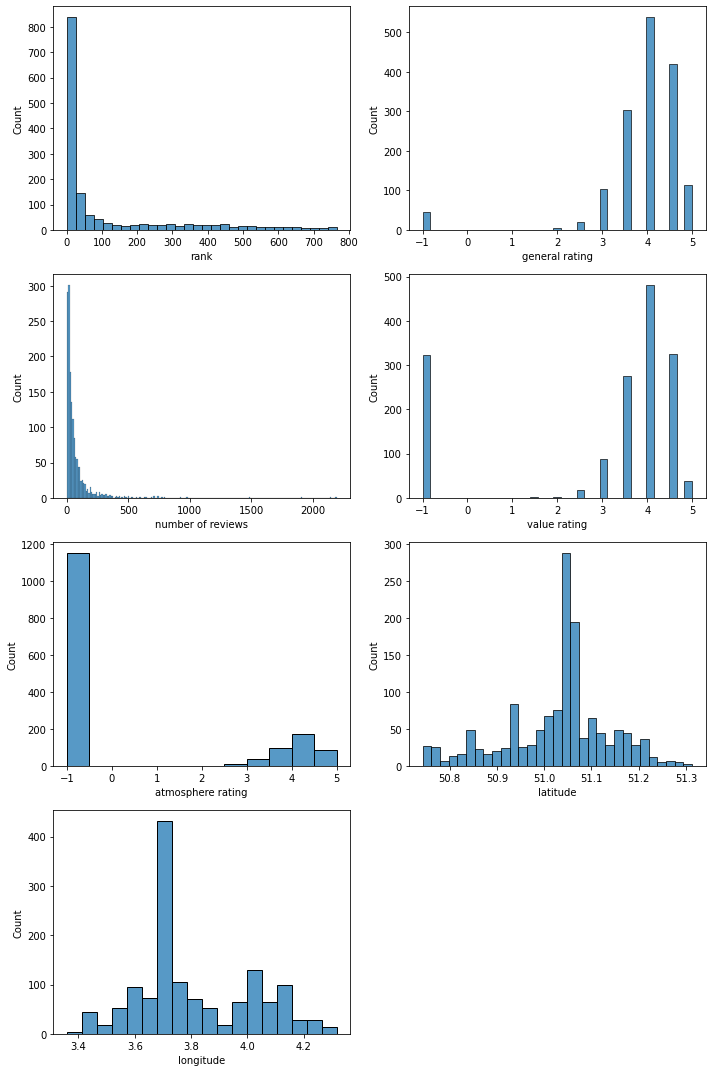

In [13]:
fig=plt.figure(figsize=(10,15))
for i, col in enumerate(numerical_cols):
    plt.subplot(4,2,i+1)
    sns.histplot(df_train[col])
fig.tight_layout()
plt.show()

#### Rank and number of reviews

we can see the rank and number of reviews have a long tail distribution so I would take the log of the data first, and then apply standardization.

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


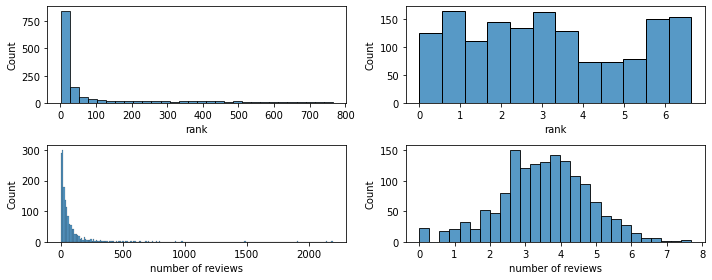

In [14]:
fig=plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
sns.histplot(df_train["rank"])
plt.subplot(2,2,2)
sns.histplot(np.log(df_train["rank"]))
plt.subplot(2,2,3)
sns.histplot(df_train["number of reviews"])
plt.subplot(2,2,4)
sns.histplot(np.log(df_train["number of reviews"]))
fig.tight_layout()
plt.show()


It already looks so much better! we will keep this but because sometimes the number of reviews is zero we will add a +1

In [15]:
##WE WILL DO THIS AFTER IMPUTATION
# df_train["lg_rank"]=np.log(df_train["rank"])
# df_train["lg_reviews"]=np.log(df_train["number of reviews"]+1)

#### General rating, atmosphere rating and value rating

look at these three again without the -1's

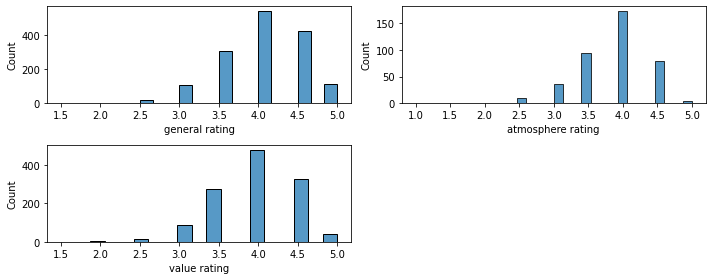

In [16]:
fig=plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
sns.histplot(df_train["general rating"].replace(-1,np.nan))
plt.subplot(2,2,2)
sns.histplot(df_train["atmosphere rating"].replace(-1,np.nan))
plt.subplot(2,2,3)
sns.histplot(df_train["value rating"].replace(-1,np.nan))
fig.tight_layout()
plt.show()

This already looks acceptable

#### Lat & lon
For the coordinates we think it's best just to apply standardization to them.

And for the missing data we wrote a script that derives the center latitude and longitude from the city and we will fill it in with those coordinates.
TODO: ik snap niet zo goed waarom we de city_center pakken en niet de exacte coordinaten, of heeft dat geen numerieke betekenis? Want nu zou je toch gwn city kunnen OHE en dat zou hetzelfde resultaat geven denk ik

In [17]:
city_centers=pd.read_csv("../input/tripadvisor/city_centers.csv")

In [18]:
df_train=df_train.merge(city_centers,on="city")
df_train

,rank,general rating,number of reviews,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,latitude,longitude,Unnamed: 0,latitude_center,longitude_center
0,4.0,3.5,21.0,False,False,3.0,-1.0,"Seafood, Belgian, European",NaN,Dinner,"Reservations, Seating, Table Service, Wheelchair Accessible",Denderleeuw,$$ - $$$,50.888222,4.076788,81,50.888138,4.062511
1,2.0,3.5,44.0,False,False,3.5,-1.0,"Italian, Pizza",Vegetarian Friendly,Dinner,"Takeout, Reservations, Seating, Wheelchair Accessible, Table Service, Serves Alcohol",Denderleeuw,$$ - $$$,50.891975,4.073112,81,50.888138,4.062511
2,1.0,4.0,207.0,False,False,4.0,3.5,"Belgian, Bar, European",Vegetarian Friendly,"Lunch, Dinner, Late Night","Reservations, Outdoor Seating, Seating, Wheelchair Accessible, Serves Alcohol, Full Bar, Table Service, Highchairs Available",Denderleeuw,$$ - $$$,50.872612,4.079612,81,50.888138,4.062511
3,6.0,4.0,44.0,False,False,4.0,-1.0,"Belgian, Dutch, European",Vegetarian Friendly,"Dinner, Drinks","Reservations, Seating, Serves Alcohol, Table Service",Brakel,$$ - $$$,NaN,NaN,9,50.797974,3.762778
4,8.0,4.5,25.0,False,False,-1.0,-1.0,"Belgian, Dutch, European",NaN,"Dinner, Breakfast, Lunch","Reservations, Seating, Table Service, Wheelchair Accessible",Brakel,$$ - $$$,50.803700,3.764335,9,50.797974,3.762778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,1.0,3.0,22.0,False,False,3.5,-1.0,NaN,NaN,"Lunch, Dinner","Reservations, Seating, Table Service",Kaprijke,$$ - $$$,51.218950,3.617083,165,51.218508,3.619077
1550,2.0,4.5,8.0,False,False,-1.0,-1.0,NaN,NaN,"Lunch, Dinner",NaN,Nukerke,$$ - $$$,50.801908,3.592342,95,50.796561,3.595467
1551,2.0,4.5,7.0,False,False,5.0,-1.0,"French, Belgian, Cafe, Seafood, European, Pub",NaN,"Lunch, Dinner, Drinks","Reservations, Takeout, Private Dining, Street Parking, Television, Serves Alcohol, Wine and Beer, Free Wifi, Accepts Credit Cards, Table Service, Dog Friendly, Family style, Non-smoking restaurants, Gift Cards Available",Denderhoutem,$$ - $$$,NaN,NaN,127,50.871780,4.018084
1552,1.0,4.0,17.0,False,False,4.5,-1.0,"Deli, Healthy, European",NaN,"Breakfast, Brunch, Lunch","Reservations, Outdoor Seating, Buffet, Seating, Parking Available, Street Parking, Highchairs Available, Serves Alcohol, Wine and Beer, Cash Only, Free Wifi, Table Service, Takeout",Aaigem,$$ - $$$,50.891996,3.949188,122,50.889417,3.936691


In [19]:
df_train.loc[df_train.latitude.isna(),"latitude"]=df_train[df_train.latitude.isna()].latitude_center
df_train.loc[df_train.longitude.isna(),"longitude"]=df_train[df_train.longitude.isna()].longitude_center

In [20]:
df_train.latitude.isna().sum()
# df_train.loc[df_train.latitude.isna(),"latitude"]

0

In [21]:
df_train.drop(columns=["Unnamed: 0","latitude_center","longitude_center"],inplace=True)

In [22]:
df_train.columns

Index(['rank', 'general rating', 'number of reviews', 'travelers choice',
       'michelin', 'value rating', 'atmosphere rating', 'cuisines',
       'special diets', 'meals', 'restaurant features', 'city', 'price_tag',
       'latitude', 'longitude'],
      dtype='object')

#### Missing values
Because our model won't like NaNs we have to replace them by something. We decided to replace them with the median of the corresponding feature. But we also think having a missing value can actually be a very good predictor. Thats why we will add a "missing" column when we have a missing value.

In [23]:
df_train["rank_missing"]=0
df_train["atmosphere_missing"]=0
df_train["value_missing"]=0
df_train["general_missing"]=0

In [24]:
df_train["atmosphere rating"]=df_train["atmosphere rating"].replace(-1,np.nan)
df_train["value rating"]=df_train["value rating"].replace(-1,np.nan)
df_train["general rating"]=df_train["general rating"].replace(-1,np.nan)

In [25]:
df_train.loc[df_train["rank"].isna(),"rank_missing"] = 1
df_train.loc[df_train["atmosphere rating"].isna(),"atmosphere_missing"] = 1
df_train.loc[df_train["value rating"].isna(),"value_missing"] = 1
df_train.loc[df_train["general rating"].isna(),"general_missing"] = 1

Imputing our missing values with the median.

In [26]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_data=imp_mean.fit_transform(df_train[["rank","general rating","value rating","atmosphere rating"]])
imputed_data

array([[4. , 3.5, 3. , 4. ],
       [2. , 3.5, 3.5, 4. ],
       [1. , 4. , 4. , 3.5],
       ...,
       [2. , 4.5, 5. , 4. ],
       [1. , 4. , 4.5, 4. ],
       [1. , 4. , 4.5, 4. ]])

In [27]:
df_train["rank"]=imputed_data[:,0]
df_train["general rating"]=imputed_data[:,1]
df_train["value rating"]=imputed_data[:,2]
df_train["atmosphere rating"]=imputed_data[:,3]

Scaling and then standardising

In [28]:
df_train["lg_rank"]=np.log(df_train["rank"])
df_train["lg_reviews"]=np.log(df_train["number of reviews"]+1)
df_train.drop(columns=["rank","number of reviews"],inplace=True)

In [29]:
df_train.head(1)

,general rating,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,latitude,longitude,rank_missing,atmosphere_missing,value_missing,general_missing,lg_rank,lg_reviews
0,3.5,False,False,3.0,4.0,"Seafood, Belgian, European",NaN,Dinner,"Reservations, Seating, Table Service, Wheelchair Accessible",Denderleeuw,$$ - $$$,50.888222,4.076788,0,1,0,0,1.386294,3.091042


### Booleans

In [30]:
df_train.select_dtypes(bool)

,travelers choice,michelin
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
1549,False,False
1550,False,False
1551,False,False
1552,False,False


In [31]:
df_train.select_dtypes(bool).isna().sum()

travelers choice    0
michelin            0
dtype: int64

no missing values! turn these into zeros and ones

In [32]:
df_train["travelers choice"]=df_train["travelers choice"].astype(int)
df_train["michelin"]=df_train["michelin"].astype(int)

### Encoding categorical variables

We already explained how we did this and used it in our sprint 1 notebook so excuse us for just copy pasting the code 😅

In [33]:
mutlihot_col = ['cuisines','special diets',"meals","restaurant features"]

In [34]:
for col in mutlihot_col:
    df_train[col]=df_train[col].fillna(col+"_missing").str.replace(" ","").str.split(",")

In [35]:
df_train[mutlihot_col]

,cuisines,special diets,meals,restaurant features
0,"[Seafood, Belgian, European]",[specialdiets_missing],[Dinner],"[Reservations, Seating, TableService, WheelchairAccessible]"
1,"[Italian, Pizza]",[VegetarianFriendly],[Dinner],"[Takeout, Reservations, Seating, WheelchairAccessible, TableService, ServesAlcohol]"
2,"[Belgian, Bar, European]",[VegetarianFriendly],"[Lunch, Dinner, LateNight]","[Reservations, OutdoorSeating, Seating, WheelchairAccessible, ServesAlcohol, FullBar, TableService, HighchairsAvailable]"
3,"[Belgian, Dutch, European]",[VegetarianFriendly],"[Dinner, Drinks]","[Reservations, Seating, ServesAlcohol, TableService]"
4,"[Belgian, Dutch, European]",[specialdiets_missing],"[Dinner, Breakfast, Lunch]","[Reservations, Seating, TableService, WheelchairAccessible]"
...,...,...,...,...
1549,[cuisines_missing],[specialdiets_missing],"[Lunch, Dinner]","[Reservations, Seating, TableService]"
1550,[cuisines_missing],[specialdiets_missing],"[Lunch, Dinner]",[restaurantfeatures_missing]
1551,"[French, Belgian, Cafe, Seafood, European, Pub]",[specialdiets_missing],"[Lunch, Dinner, Drinks]","[Reservations, Takeout, PrivateDining, StreetParking, Television, ServesAlcohol, WineandBeer, FreeWifi, AcceptsCreditCards, TableService, DogFriendly, Familystyle, Non-smokingrestaurants, GiftCardsAvailable]"
1552,"[Deli, Healthy, European]",[specialdiets_missing],"[Breakfast, Brunch, Lunch]","[Reservations, OutdoorSeating, Buffet, Seating, ParkingAvailable, StreetParking, HighchairsAvailable, ServesAlcohol, WineandBeer, CashOnly, FreeWifi, TableService, Takeout]"


In [36]:
#multi hot encoding of the meals, restaurant features ,cuisines and diets
from sklearn.preprocessing import MultiLabelBinarizer

mlbs=[]
columns=["meals","restaurant features","cuisines","special diets"]
mh_encodings=[]
for col in columns:
    mlb= MultiLabelBinarizer()
    mlbs.append(mlb)
    # X=df_train[col].str.replace(" ","").str.split(",").fillna("X").to_list()
    #I want a list of sets that i can then pass to the MultiLabelBinarizer
    # lijst=[set(i) for i in X]
    mh_encodings.append(mlb.fit_transform(df_train[col]))


In [37]:
for i in mh_encodings:
    print(i.shape)

(1554, 7)
(1554, 39)
(1554, 91)
(1554, 5)


In [38]:
for i in mlbs:
    print(i.classes_)

['Breakfast' 'Brunch' 'Dinner' 'Drinks' 'LateNight' 'Lunch'
 'meals_missing']
['AcceptsAmericanExpress' 'AcceptsCreditCards' 'AcceptsDiscover'
 'AcceptsMastercard' 'AcceptsVisa' 'BYOB' 'Beach' 'Buffet' 'CashOnly'
 'Delivery' 'DigitalPayments' 'DogFriendly' 'Familystyle' 'FreeWifi'
 'Freeoff-streetparking' 'FullBar' 'GiftCardsAvailable'
 'HighchairsAvailable' 'JazzBar' 'LiveMusic' 'Non-smokingrestaurants'
 'OutdoorSeating' 'ParkingAvailable' 'Playgrounds' 'PrivateDining'
 'Reservations' 'Seating' 'ServesAlcohol' 'Sportsbars' 'StreetParking'
 'TableService' 'Takeout' 'Television' 'ValetParking' 'ValidatedParking'
 'Waterfront' 'WheelchairAccessible' 'WineandBeer'
 'restaurantfeatures_missing']
['Afghan' 'African' 'Albanian' 'American' 'Apulian' 'Arabic' 'Argentinean'
 'Asian' 'Assyrian' 'Australian' 'Bar' 'Barbecue' 'Beerrestaurants'
 'Belgian' 'Brazilian' 'BrewPub' 'British' 'Cafe' 'Cajun&Creole'
 'Campania' 'Caribbean' 'Central-Italian' 'CentralAmerican' 'CentralAsian'
 'CentralEuropea

One hot encode the city dropped this featue because it is redundant if we have latitude and longitude of the restaurant

In [39]:
# from sklearn.preprocessing import OneHotEncoder
# enc=OneHotEncoder(sparse=False,handle_unknown="ignore")
# enc.fit(np.array(df_train["city"]).reshape(-1,1))
# oh_cities=enc.transform(np.array(df_train["city"]).reshape(-1,1))
# oh_cities

In [40]:
df_train.drop(columns=["cuisines","special diets","meals","restaurant features","city"],inplace=True)
df_train

,general rating,travelers choice,michelin,value rating,atmosphere rating,price_tag,latitude,longitude,rank_missing,atmosphere_missing,value_missing,general_missing,lg_rank,lg_reviews
0,3.5,0,0,3.0,4.0,$$ - $$$,50.888222,4.076788,0,1,0,0,1.386294,3.091042
1,3.5,0,0,3.5,4.0,$$ - $$$,50.891975,4.073112,0,1,0,0,0.693147,3.806662
2,4.0,0,0,4.0,3.5,$$ - $$$,50.872612,4.079612,0,0,0,0,0.000000,5.337538
3,4.0,0,0,4.0,4.0,$$ - $$$,50.797974,3.762778,0,1,0,0,1.791759,3.806662
4,4.5,0,0,4.0,4.0,$$ - $$$,50.803700,3.764335,0,1,1,0,2.079442,3.258097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,3.0,0,0,3.5,4.0,$$ - $$$,51.218950,3.617083,0,1,0,0,0.000000,3.135494
1550,4.5,0,0,4.0,4.0,$$ - $$$,50.801908,3.592342,0,1,1,0,0.693147,2.197225
1551,4.5,0,0,5.0,4.0,$$ - $$$,50.871780,4.018084,0,1,0,0,0.693147,2.079442
1552,4.0,0,0,4.5,4.0,$$ - $$$,50.891996,3.949188,0,1,0,0,0.000000,2.890372


### Standardizing

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data=scaler.fit_transform(df_train[["general rating","value rating","atmosphere rating","latitude","longitude","lg_rank","lg_reviews"]])
scaled_data.shape

(1554, 7)

In [42]:
df_train["general rating"]=scaled_data[:,0]
df_train["value rating"]=scaled_data[:,1]
df_train["atmosphere rating"]=scaled_data[:,2]
df_train["latitude"]=scaled_data[:,3]
df_train["longitude"]=scaled_data[:,4]
df_train["lg_rank"]=scaled_data[:,5]
df_train["lg_reviews"]=scaled_data[:,6]

### Label

Our label is the pice tag, we will ordinal encode this

In [43]:
df_train.loc[df_train.price_tag=="$","price_tag"]=0
df_train.loc[df_train.price_tag=="$$ - $$$","price_tag"]=1
df_train.loc[df_train.price_tag=="$$$$","price_tag"]=2

In [44]:
y_train=df_train["price_tag"].astype(int)
df_train.drop(columns=["price_tag"],inplace=True)

Finally putting it all together

In [45]:
# oh_cities.shape
mh_encodings[0].shape

(1554, 7)

In [46]:
mh_encodings[1].shape

(1554, 39)

In [47]:
##testing if the shape is correct
np.concatenate((mh_encodings[0],mh_encodings[1]),axis=1).shape

(1554, 46)

In [48]:
df_train

,general rating,travelers choice,michelin,value rating,atmosphere rating,latitude,longitude,rank_missing,atmosphere_missing,value_missing,general_missing,lg_rank,lg_reviews
0,-0.942944,0,0,-2.093911,0.134304,-1.228275,1.240307,0,1,0,0,-0.920493,-0.286641
1,-0.942944,0,0,-1.007092,0.134304,-1.194586,1.223032,0,1,0,0,-1.272906,0.255239
2,-0.032798,0,0,0.079728,-1.696477,-1.368416,1.253582,0,0,0,0,-1.625319,1.414445
3,-0.032798,0,0,0.079728,0.134304,-2.038458,-0.235375,0,1,0,0,-0.714345,0.255239
4,0.877348,0,0,0.079728,0.134304,-1.987050,-0.228057,0,1,1,0,-0.568081,-0.160145
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,-1.853091,0,0,-1.007092,0.134304,1.740752,-0.920066,0,1,0,0,-1.625319,-0.252981
1550,0.877348,0,0,0.079728,0.134304,-2.003139,-1.036335,0,1,1,0,-1.272906,-0.963455
1551,0.877348,0,0,2.253367,0.134304,-1.375886,0.964430,0,1,0,0,-1.272906,-1.052643
1552,-0.032798,0,0,1.166548,0.134304,-1.194395,0.640657,0,1,0,0,-1.625319,-0.438592


In [49]:
X_train=np.concatenate((mh_encodings[0],mh_encodings[1],mh_encodings[2],mh_encodings[3],df_train),axis=1)
X_train.shape

(1554, 155)

We will also make a variable, feature labels, that will tell us where each feature in our array comes from.

In [50]:
feature_labels=[]

In [51]:
# feature_labels.extend(enc.categories_[0])
for i in mlbs:
    feature_labels.extend(i.classes_)
feature_labels.extend(df_train.columns)

In [52]:
len(feature_labels), feature_labels[:3]

(155, ['Breakfast', 'Brunch', 'Dinner'])

#### Now apply the same preprocessing for our test set


First, fill in the missing locations with the city_centers

In [53]:
df_test=df_test.merge(city_centers,on="city")

In [54]:
df_test.loc[df_test.latitude.isna(),"latitude"]=df_test[df_test.latitude.isna()].latitude_center
df_test.loc[df_test.longitude.isna(),"longitude"]=df_test[df_test.longitude.isna()].longitude_center

In [55]:
df_test.latitude.isna().sum()

0

In [56]:
df_test.drop(columns=["Unnamed: 0","latitude_center","longitude_center"],inplace=True)

In [57]:
#inserting the missing columns
df_test["rank_missing"]=0
df_test["atmosphere_missing"]=0
df_test["value_missing"]=0
df_test["general_missing"]=0
df_test["atmosphere rating"]=df_test["atmosphere rating"].replace(-1,np.nan)
df_test["value rating"]=df_test["value rating"].replace(-1,np.nan)
df_test["general rating"]=df_test["general rating"].replace(-1,np.nan)
df_test.loc[df_test["rank"].isna(),"rank_missing"] = 1
df_test.loc[df_test["atmosphere rating"].isna(),"atmosphere_missing"] = 1
df_test.loc[df_test["value rating"].isna(),"value_missing"] = 1
df_test.loc[df_test["general rating"].isna(),"general_missing"] = 1


Imputing our data

In [58]:
#inputing our data
imputed_data=imp_mean.transform(df_test[["rank","general rating","value rating","atmosphere rating"]])
print(imputed_data.shape)
df_test["rank"]=imputed_data[:,0]
df_test["general rating"]=imputed_data[:,1]
df_test["value rating"]=imputed_data[:,2]
df_test["atmosphere rating"]=imputed_data[:,3]
df_test["lg_rank"]=np.log(df_test["rank"])
df_test["lg_reviews"]=np.log(df_test["number of reviews"]+1)
df_test.drop(columns=["rank","number of reviews"],inplace=True)
df_test["travelers choice"]=df_test["travelers choice"].astype(int)
df_test["michelin"]=df_test["michelin"].astype(int)

(389, 4)


Multihot encoding

In [59]:
for col in mutlihot_col:
    df_test[col]=df_test[col].fillna(col+"_missing").str.replace(" ","").str.split(",")

In [60]:
#multihot encoding
# mlbs=[]
columns=["meals","restaurant features","cuisines","special diets"]
mh_encodings=[]
for i,col in enumerate(columns):
    mlb= mlbs[i]
    mh_encodings.append(mlb.transform(df_test[col]))


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) ['DriveThru'] will be ignored
  "unknown class(es) {0} will be ignored".format(sorted(unknown, key=str))
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) ['Ethiopian', 'Filipino', 'Malaysian', 'Taiwanese'] will be ignored
  "unknown class(es) {0} will be ignored".format(sorted(unknown, key=str))


We can already see that there are classs in our test set that don't appear in our trainingsset, we will ignore these

In [61]:
#OH encoding
# enc=OneHotEncoder(sparse=False,handle_unknown="infrequent_if_exist")
# enc.transform(np.array(df_test["city"]).reshape(-1,1))
# oh_cities=enc.transform(np.array(df_test["city"]).reshape(-1,1))
df_test.drop(columns=["cuisines","special diets","meals","restaurant features","city"],inplace=True)


In [62]:
#scaling
# scaler = StandardScaler()
scaled_data=scaler.transform(df_test[["general rating","value rating","atmosphere rating","latitude","longitude","lg_rank","lg_reviews"]])
scaled_data.shape
df_test["general rating"]=scaled_data[:,0]
df_test["value rating"]=scaled_data[:,1]
df_test["atmosphere rating"]=scaled_data[:,2]
df_test["latitude"]=scaled_data[:,3]
df_test["longitude"]=scaled_data[:,4]
df_test["lg_rank"]=scaled_data[:,5]
df_test["lg_reviews"]=scaled_data[:,6]
df_test.loc[df_test.price_tag=="$","price_tag"]=0
df_test.loc[df_test.price_tag=="$$ - $$$","price_tag"]=1
df_test.loc[df_test.price_tag=="$$$$","price_tag"]=2

y_test=df_test["price_tag"].astype(int)
df_test.drop(columns=["price_tag"],inplace=True)



In [63]:
X_test=np.concatenate((mh_encodings[0],mh_encodings[1],mh_encodings[2],mh_encodings[3],df_test),axis=1)

In [64]:
X_train.shape,y_train.shape, X_test.shape,y_test.shape

((1554, 155), (1554,), (389, 155), (389,))

### Baseline

In [65]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train)
accuracy_score(y_test, rf.predict(X_test))

0.7660668380462725

This is already a good result, we can also find the features that were used the most in the descision trees to make splits (the important features)

In [66]:
rf.feature_importances_

array([4.10291547e-03, 3.71751723e-03, 2.69687957e-02, 3.22500418e-03,
       1.97404979e-03, 7.05451047e-03, 1.05630309e-02, 4.17187988e-04,
       5.36557618e-03, 0.00000000e+00, 2.51314335e-03, 1.80998988e-03,
       0.00000000e+00, 0.00000000e+00, 3.56434556e-04, 4.09723050e-04,
       4.32329076e-03, 3.61857540e-03, 3.33269176e-04, 7.71155635e-04,
       4.47179006e-03, 1.18242183e-03, 3.96217357e-03, 3.21939793e-03,
       9.25648674e-03, 0.00000000e+00, 0.00000000e+00, 6.99421440e-04,
       7.03373284e-03, 5.56913131e-03, 0.00000000e+00, 3.65971552e-03,
       8.68639189e-02, 1.79016365e-02, 2.41483027e-02, 0.00000000e+00,
       1.83330549e-03, 7.41434828e-02, 3.03199912e-02, 1.88601450e-03,
       0.00000000e+00, 2.32071718e-03, 0.00000000e+00, 1.27715554e-02,
       2.74371148e-03, 3.14036400e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.16271739e-03, 0.00000000e+00, 0.00000000e+00,
      

In [67]:
importances=pd.DataFrame(dict(cols=feature_labels, imp=rf.feature_importances_))

In [68]:
importances.sort_values("imp",ascending=False).head(10)

,cols,imp
32,Reservations,0.086864
154,lg_reviews,0.081942
37,TableService,0.074143
153,lg_rank,0.067093
147,latitude,0.058247
148,longitude,0.047518
144,michelin,0.034302
45,restaurantfeatures_missing,0.031404
145,value rating,0.030461
38,Takeout,0.030320


Above we can see  the 10 most important features for our random forest ensemble. It is interesting to see that we were right, the fact that a feature is missing is important for the classifier, "restaurant features missing" is in the top 10 as a feature. It is also interesting to see that Table service and reviews are the most inmortant features to determine our price tag.

### Model selection

Our first idea was to try out a lot of different classifiers with default parameters, look which ones have the best accuracy and then do a grid search on the best three models and pick the best one. When we finished this we realised that our dataset is heavily imbalanced and we have to do something about this.


*NOTE: we have class imabalance so we chose models that have the class weight property*

we must choose our performance metric carefully because of the class imbalance [this article]("https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a") for inspiration

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
def plot_cm(classifier):
    cm=confusion_matrix(y_test, classifier.predict(X_test))
    df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    sns.heatmap(df_cm, cbar=False, annot=True, square=True, fmt='.0f',
                annot_kws={'size': 10})

In [70]:
classifiers=["svc linear","svc rbf","Logistic Regression","Naive Bayes","Light Gradient Boosting machine(LGBM)","xgboost","catboost"]
scores_list=[]

**SVC linear**

Quick experiment to see the effect of the class weight.

In [71]:
clf=SVC(kernel="linear", C=0.025)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)

The score is:  0.7634961439588689
The balanced accuracy is:  0.33749999999999997


In [72]:
clf=SVC(kernel="linear", C=0.025,class_weight="balanced")
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.6683804627249358
The balanced accuracy is:  0.6683038808038808


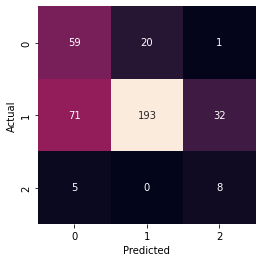

In [73]:
plot_cm(clf)

**SVC rbf**


In [74]:
clf = SVC(gamma=2, C=1,class_weight="balanced")
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.7583547557840618
The balanced accuracy is:  0.3322072072072072


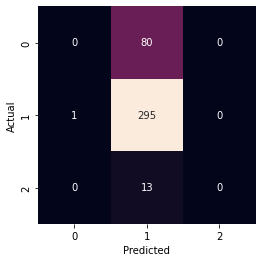

In [75]:
plot_cm(clf)

We can already see that by carefully looking at the confusion matrix and not blindly at our classification score we can already see that eventhough this classifier has a better score that the linear SVC, it predicts 1 for almost every input so the model is actually really bad.

We can also confirm that the balanced accuracy is a better performance metric.

**Logistic geression**

In [76]:
clf=LogisticRegression(random_state=0,max_iter=500,class_weight="balanced")
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.6863753213367609
The balanced accuracy is:  0.6547124047124048


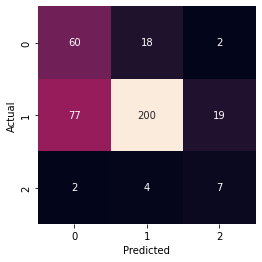

In [77]:
plot_cm(clf)

**Naieve Bayes**

In [78]:
clf=GaussianNB() ##here we don't need class weights because the probabilities are calculated from our classes
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.19023136246786632
The balanced accuracy is:  0.4253984753984754


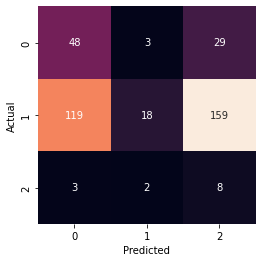

In [79]:
plot_cm(clf)

**KNN**

In [80]:
# clf=KNeighborsClassifier()
# clf.fit(X_train,y_train)
# mscore=clf.score(X_test,y_test)
# print("The score is: ",mscore)
# scores_list.append(mscore)

**Random forest**

In [81]:
# clf=RandomForestClassifier(300)
# clf.fit(X_train,y_train)
# mscore=clf.score(X_test,y_test)
# print("The score is: ",mscore)
# scores_list.append(mscore)

**Light gradient boosting machine (LGBM)**

In [82]:
clf=LGBMClassifier(random_state=0,class_weight="balanced")
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.7712082262210797
The balanced accuracy is:  0.5698717948717948


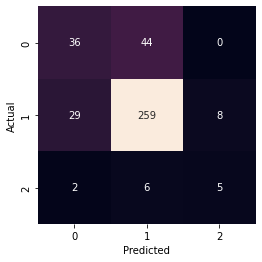

In [83]:
plot_cm(clf)

**XGBOOST**

With help from [Unbalanced multiclass data with XGBoost]("https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost")

In [84]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [85]:
clf=XGBClassifier(use_label_encoder=False,random_state=0)
clf.fit(X_train,y_train,sample_weight=classes_weights)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.7737789203084833
The balanced accuracy is:  0.5525641025641026


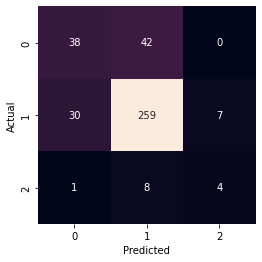

In [86]:
plot_cm(clf)

**Catboost**

In [87]:
classes_weights

array([0.41639871, 0.41639871, 0.41639871, ..., 0.41639871, 0.41639871,
       0.41639871])

In [88]:
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 2.072, 1: 0.41639871382636656, 2: 8.633333333333333}

In [89]:
clf=CatBoostClassifier(random_state=0,class_weights=class_weights,silent=True)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.7506426735218509
The balanced accuracy is:  0.5760654885654884


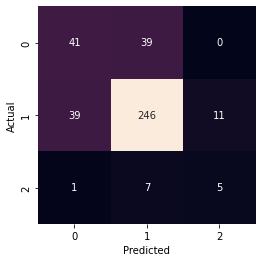

In [90]:
plot_cm(clf)

Putting it all together

In [91]:
scores_list

[0.6683038808038808,
 0.3322072072072072,
 0.6547124047124048,
 0.4253984753984754,
 0.5698717948717948,
 0.5525641025641026,
 0.5760654885654884]

In [92]:
sb=pd.DataFrame(list(zip(classifiers,scores_list)),columns=['Classifier','Score'])
sb.sort_values("Score")

,Classifier,Score
1,svc rbf,0.332207
3,Naive Bayes,0.425398
5,xgboost,0.552564
4,Light Gradient Boosting machine(LGBM),0.569872
6,catboost,0.576065
2,Logistic Regression,0.654712
0,svc linear,0.668304


### RandomisedSearch
Now we will try to squeeze the last drops of performance out of our best models.

We wil make sure to adjust our performance metric and use StratifiedKFold to maintain the same distribution of classes in our folds.

In [93]:
from sklearn.model_selection import StratifiedKFold

linear_svc_grid={
    "C":[0.01,0.1,1,10,100],
}
# LGBM_grid = {'n_estimators': [50, 100, 150, 200],
#         'max_depth': [4, 8, 12],
#         'learning_rate': [0.05, 0.1, 0.15]}
xgboost_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }

catboost_grid={'learning_rate': [0.01, 0.1,1],
        'n_estimators':[100,200,400],
        'depth': [4, 10,20,30],
        'l2_leaf_reg': [0,2, 5, 9]
              }

# rf_grid={
#     "n_estimators":[100,200,300,400],
#     "max_depth":[1,2,3,4,5,6,7,8],
#     'min_samples_leaf':[2,4]
# }

log_grid={
    "penalty":["l1", "l2", "elasticnet" , "none" ],
    "C":[0.01,0.1,1,10],
    "max_iter":[100,150,200,300]
}
final_class=['linear_svc','xgboost_classifier','catboost_classifier','logistic_regression']
final_scores=[]

In [94]:
from joblib import dump, load


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


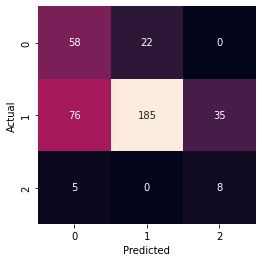

In [95]:
linear_svc_clf=RandomizedSearchCV(estimator=SVC(kernel="linear",class_weight="balanced"),param_distributions=linear_svc_grid,scoring="balanced_accuracy",n_jobs=-1,cv=StratifiedKFold(),n_iter=100)
linear_svc_clf.fit(X_train,y_train)
dump(linear_svc_clf, 'linear_svc_clf.joblib')

pred=linear_svc_clf.predict(X_test)
balanced_score=balanced_accuracy_score(y_test,pred)
final_scores.append(balanced_score)
plot_cm(linear_svc_clf)

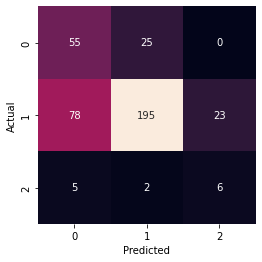

In [96]:
xgboost_clf=RandomizedSearchCV(estimator=XGBClassifier(use_label_encoder=False),param_distributions=xgboost_grid,scoring="balanced_accuracy",n_jobs=-1,cv=StratifiedKFold(),n_iter=100)

#Fit the model
xgboost_clf.fit(X_train,y_train,sample_weight=classes_weights)
#Score and Store the model
dump(xgboost_clf, 'xgboost_clf.joblib') 

pred=xgboost_clf.predict(X_test)
balanced_score=balanced_accuracy_score(y_test,pred)
final_scores.append(balanced_score)
plot_cm(xgboost_clf)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
287 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
265 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 5130, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model, callbacks, log_cout, log_cerr)
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 2347, in _fit
    callbacks=callb

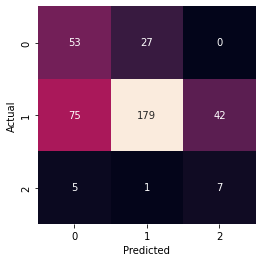

In [97]:
catboost_clf=RandomizedSearchCV(estimator=CatBoostClassifier(class_weights=class_weights,silent=True),param_distributions=catboost_grid,scoring="balanced_accuracy",n_jobs=-1,cv=StratifiedKFold(),n_iter=100)

#Fit the model
catboost_clf.fit(X_train,y_train)
dump(catboost_clf, 'catboost_clf.joblib') 

pred=catboost_clf.predict(X_test)
balanced_score=balanced_accuracy_score(y_test,pred)
final_scores.append(balanced_score)
plot_cm(catboost_clf)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/li

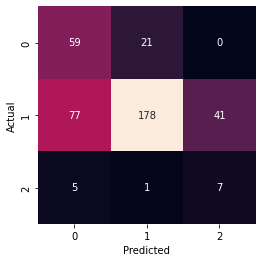

In [98]:
log_reg_clf=RandomizedSearchCV(estimator=LogisticRegression(class_weight="balanced"),param_distributions=log_grid,scoring="balanced_accuracy",n_jobs=-1,cv=StratifiedKFold(),n_iter=100)

#Fit the model
log_reg_clf.fit(X_train,y_train)

dump(log_reg_clf, 'logistic_regression.joblib') 
#Score and Store the model
pred=log_reg_clf.predict(X_test)
balanced_score=balanced_accuracy_score(y_test,pred)
final_scores.append(balanced_score)
plot_cm(log_reg_clf)

In [99]:
final_scores

[0.6551282051282051,
 0.6026074151074151,
 0.6018970893970894,
 0.6257709632709633]

In [100]:
final_class

['linear_svc',
 'xgboost_classifier',
 'catboost_classifier',
 'logistic_regression']

In [101]:
final_sb=pd.DataFrame(list(zip(final_class,final_scores)),columns=['Classifier','Score'])
final_sb

,Classifier,Score
0,linear_svc,0.655128
1,xgboost_classifier,0.602607
2,catboost_classifier,0.601897
3,logistic_regression,0.625771


In [102]:
importances=pd.DataFrame(dict(cols=feature_labels, imp=linear_svc_clf.best_estimator_.coef_[0]))
importances.sort_values("imp",ascending=False).head(10)

,cols,imp
38,Takeout,0.377797
153,lg_rank,0.288305
145,value rating,0.199507
82,FastFood,0.177117
43,WheelchairAccessible,0.136139
63,Cafe,0.135535
106,MiddleEastern,0.125464
44,WineandBeer,0.121143
39,Television,0.115692
132,Turkish,0.111528


In [103]:
importances=pd.DataFrame(dict(cols=feature_labels, imp=xgboost_clf.best_estimator_.feature_importances_))
importances.sort_values("imp",ascending=False).head(10)

,cols,imp
32,Reservations,0.148109
83,French,0.082906
144,michelin,0.074347
37,TableService,0.057006
137,GlutenFreeOptions,0.054946
81,European,0.041466
120,Seafood,0.036413
38,Takeout,0.031936
149,rank_missing,0.029421
146,atmosphere rating,0.029314


In [104]:
importances=pd.DataFrame(dict(cols=feature_labels, imp=catboost_clf.best_estimator_.feature_importances_))
importances.sort_values("imp",ascending=False).head(10)

,cols,imp
83,French,21.362781
144,michelin,16.037678
154,lg_reviews,7.938330
120,Seafood,7.504201
32,Reservations,6.506453
153,lg_rank,6.302685
37,TableService,5.345717
150,atmosphere_missing,4.296200
137,GlutenFreeOptions,3.303151
31,PrivateDining,2.831799


In [105]:
importances=pd.DataFrame(dict(cols=feature_labels, imp=log_reg_clf.best_estimator_.coef_[0]))
importances.sort_values("imp",ascending=False).head(10)

,cols,imp
153,lg_rank,0.353711
38,Takeout,0.340482
150,atmosphere_missing,0.199693
145,value rating,0.157130
82,FastFood,0.138581
63,Cafe,0.129901
3,Drinks,0.110485
43,WheelchairAccessible,0.074743
0,Breakfast,0.074630
136,cuisines_missing,0.066204


Last resort if nothing works to extract expensive restaurants, use anomaly based approach using isolation forest or PCA and binary classification on cheap restaurants.

TODO: conclusie schrijven van dat x de beste is en dan als input restaurants krijgen van idea1 en die predicten.